1. Baseline, eyes open
2. Baseline, eyes closed
3. Task 1 (open and close left or right fist)
4. Task 2 (imagine opening and closing left or right fist)
5. Task 3 (open and close both fists or both feet)
6. Task 4 (imagine opening and closing both fists or both feet)
7. Task 1
8. Task 2
9. Task 3
10. Task 4
11. Task 1
12. Task 2
13. Task 3
14. Task 4

### 讀取

In [312]:
import os
import numpy as np
import pyedflib

# Subject
subject = 'S010'

# # 定義讀取的檔案列表和對應的標籤
read_list = ['R03', 'R04', 'R05', 'R06', 'R07', 'R08', 'R09', 'R10', 'R11', 'R12', 'R13', 'R14']
data_label = [1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4]

# ## 1 vs 4
# read_list = ['R03', 'R06', 'R07', 'R10', 'R11', 'R14']
# data_label = [1, 4, 1, 4, 1, 4]

# ## 2 vs 4
# read_list = ['R04', 'R06', 'R08', 'R10', 'R12', 'R14']
# data_label = [2, 4, 2, 4, 2, 4]

# 創建信號名稱到標籤的映射
signal_to_label = dict(zip(read_list, data_label))

# 初始化存放所有信號的字典
read_dict = {}

# 讀取所有 EDF 檔案並存入 read_dict
for i in read_list:
    # 打開 EDF 檔案
    file_path = '/Users/Jer_ry/Library/Mobile Documents/com~apple~CloudDocs/大四上/類神經網路/期末報告/physioNet/'+subject+'/' +subject+ i + '.edf'
    edf_reader = pyedflib.EdfReader(file_path)
    # 獲取信號數量
    n_signals = edf_reader.signals_in_file
    # 讀取所有信號數據
    signals = np.zeros((n_signals, edf_reader.getNSamples()[0]))
    for j in range(n_signals):
        signals[j, :] = edf_reader.readSignal(j)
    read_dict[i] = signals
    # 關閉 EDF 檔案
    edf_reader.close()
    # 打印信號數據和通道名稱
    print(f"Signals Shape for {i}: {signals.shape}")

# 設置分段參數
segment = 16  # 每個 segment 的長度
overlap = 0.5  # 重疊比例
step = int(segment * (1 - overlap))  # 計算步長

Signals Shape for R03: (64, 19680)
Signals Shape for R04: (64, 19680)
Signals Shape for R05: (64, 19680)
Signals Shape for R06: (64, 19680)
Signals Shape for R07: (64, 19680)
Signals Shape for R08: (64, 19680)
Signals Shape for R09: (64, 19680)
Signals Shape for R10: (64, 19680)
Signals Shape for R11: (64, 19680)
Signals Shape for R12: (64, 19680)
Signals Shape for R13: (64, 19680)
Signals Shape for R14: (64, 19680)


### Segmentaiion

In [313]:
# 初始化存放所有 segment 和標籤的列表
all_data = []
all_labels = []

for key in read_list:
    signal = read_dict[key]  # 獲取當前信號，形狀為 (64, 20000)
    channels, total_samples = signal.shape
    signal_segments = []
    
    # 計算可以提取多少個 segment
    number_of_segments = int((total_samples - segment) / step) + 1
    
    for i in range(number_of_segments):
        start = i * step
        end = start + segment
        if end > total_samples:
            break  # 避免超出信號長度
        seg = signal[:, start:end]  # 提取 segment，形狀為 (64, segment)
        seg_flat = seg.reshape(-1)  # 展平成一維向量，形狀為 (64 * segment,)
        signal_segments.append(seg_flat)
    
    # 將當前信號的 segments 轉換為 numpy 數組
    signal_segments = np.array(signal_segments)
    
    # 如果行數為奇數，添加最後一行使其成為偶數
    if signal_segments.shape[0] % 2 != 0:
        signal_segments = np.vstack((signal_segments, signal_segments[-1]))
    
    # 獲取對應的標籤
    label = signal_to_label[key]
    num_segments = signal_segments.shape[0]
    labels = np.full((num_segments,), label)
    
    # 將 segments 和標籤添加到全局列表
    all_data.append(signal_segments)
    all_labels.append(labels)

# 將所有數據和標籤合併為單個數組
all_data = np.vstack(all_data)  # 形狀為 (total_num_segments, 1024)
all_labels = np.concatenate(all_labels)  # 形狀為 (total_num_segments,)
print(f"Data Shape: {all_data.shape}, Labels Shape: {all_labels.shape}")

Data Shape: (29520, 1024), Labels Shape: (29520,)


2500 * 12 = 3000

In [314]:
# 使用 sklearn 的 train_test_split 一資料劃分
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    all_data, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (23616, 1024)
X_test shape: (5904, 1024)
y_train shape: (23616,)
y_test shape: (5904,)


In [315]:
# normalization
# before normalize reshape data back to raw data shape
X_train_2d = X_train.reshape([-1, 64])
X_test_2d = X_test.reshape([-1, 64])

# min-max normalization
from sklearn.preprocessing import MinMaxScaler
scaler3 = MinMaxScaler().fit(X_train)
X_train_norm1 = scaler3.transform(X_train)
X_test_norm1 = scaler3.transform(X_test)
print('After normalization, the shape of training feature:', X_train_norm1.shape,
      '\nAfter normalization, the shape of test feature:', X_test_norm1.shape)

After normalization, the shape of training feature: (23616, 1024) 
After normalization, the shape of test feature: (5904, 1024)


In [316]:
# 將 noramalize 後的數據重新塑形為 3D，以便輸入到 AutoEncoder  中
segment_length = segment
no_feature = 64
X_train_norm1 = X_train_norm1 .reshape([-1, segment_length, no_feature])
X_test_norm1 = X_test_norm1.reshape([-1, segment_length, no_feature])
y_train = y_train.reshape([-1, segment_length, 1])
y_test = y_test.reshape([-1, segment_length, 1])
print('After reshape, the shape of training feature:', X_train_norm1.shape,
      '\nAfter reshape, the shape of test feature:', X_test_norm1.shape)

After reshape, the shape of training feature: (23616, 16, 64) 
After reshape, the shape of test feature: (5904, 16, 64)


## 可視化原始資料：
* 圖示內容：展示了指定 EDF 文件中某一通道的完整信號數據。
* 目的：
  * 確認信號的整體形態（例如波形、振幅範圍、是否有明顯異常）。
  * 幫助理解信號是連續的時間序列數據。
* 應用場景：檢查讀取的數據是否正確無誤，以及探索每個通道是否有明顯的噪聲或失真。

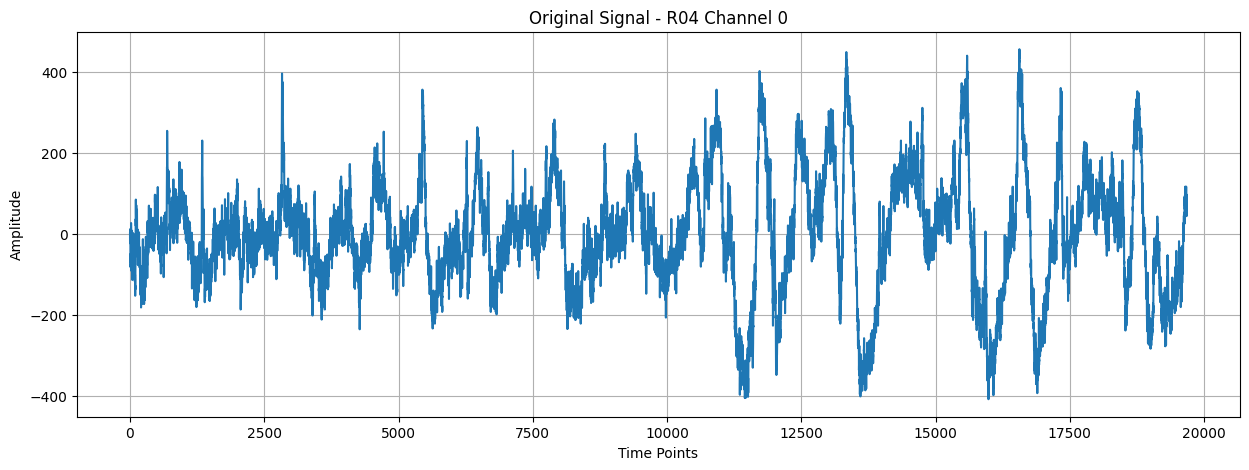

In [290]:
import matplotlib.pyplot as plt

# 可視化一個檔案中的第一個通道信號
file_key = 'R04'  # 指定檔案名稱
signal = read_dict[file_key]  # 取得信號數據
channel = 0  # 指定通道

plt.figure(figsize=(15, 5))
plt.plot(signal[channel, :])
plt.title(f"Original Signal - {file_key} Channel {channel}")
plt.xlabel("Time Points")
plt.ylabel("Amplitude")
plt.grid()
plt.show()


### 可視化分段訊號：
* 圖示內容：展示了分段後的信號數據，其中一段的某一通道信號。
* 目的：
  * 確保分段過程正確，信號段的長度符合設定的 segment 參數。
  * 檢查分段後的信號是否保留了有用的特徵（如明顯的振幅變化或周期性模式）。
* 解讀方式：
  * 分段完整性：確保每段信號都保留了足夠的特徵。例如，分段後的信號仍能清晰呈現周期性或尖峰特徵。
  * 邊界效應：檢查分段的頭尾部分是否出現明顯的邊界效應（如信號截斷），這可能影響後續分析。
  * 對比不同段：不同段之間是否有明顯差異，可能反映時間內的信號變化。
* 下一步：
  * 如果信號分段後特徵不明顯，考慮調整 segment 或 overlap 的參數。
* 應用場景：驗證信號分段過程是否有效，避免錯誤的截斷或丟失重要數據。

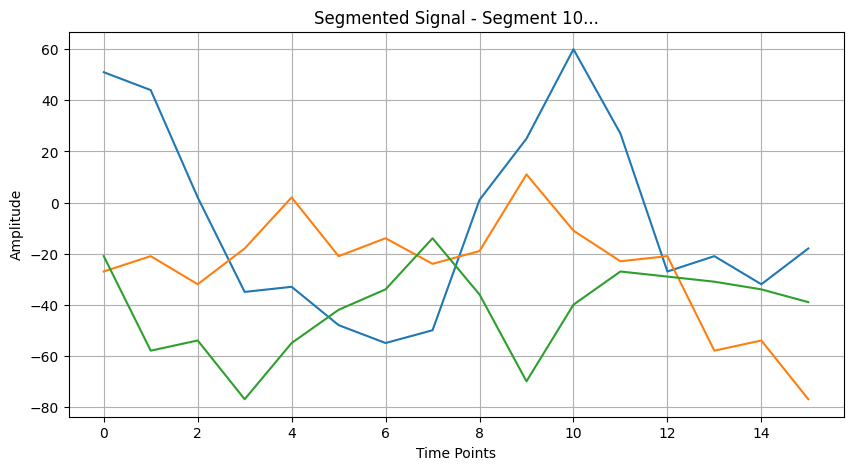

In [291]:
# 可視化分段信號
segment_id = 10  # 指定要檢視的 segment
signal_segment = all_data[segment_id].reshape(-1, segment)  # 還原為原始形狀
signal_segment_1 = all_data[segment_id+1].reshape(-1, segment)  # 還原為原始形狀
signal_segment_2 = all_data[segment_id+2].reshape(-1, segment)  # 還原為原始形狀

plt.figure(figsize=(10, 5))
plt.plot(signal_segment[0, :], label='Segment 1')  # 顯示第一個通道的片段
plt.plot(signal_segment_1[0, :], label='Segment 2')  # 顯示第一個通道的片段
plt.plot(signal_segment_2[0, :], label='Segment 3')  # 顯示第一個通道的片段
plt.title(f"Segmented Signal - Segment {segment_id}...")
plt.xlabel("Time Points")
plt.ylabel("Amplitude")
plt.grid()
plt.show()


### 訊號分佈直方圖
* 圖示內容：展示所有信號數據的值分佈情況，以直方圖形式顯示。
* 目的：
  * 檢查數據值範圍，是否存在異常的極值（例如高 noise）。
  * 了解訊號值是否呈常態分佈或其他特定模式。
* 解讀方式：
  * 集中程度：數據是否集中在特定區間？例如，腦波信號通常有較小的振幅範圍，過大的範圍可能提示噪聲。
  * 極值檢查：直方圖中是否有異常的極值（長尾分佈或孤立峰值），這些可能是伪影或測量誤差。
  * 分佈形態：是否接近正態分佈？大多數信號的分佈應該對稱或略有偏態。
* 下一步：
  * 如果數據分佈異常，需進一步濾波處理或截除極端值。
* 應用場景：在正規化或特徵提取之前檢查數據分佈是否需要特殊處理（例如去除極值或平滑）。

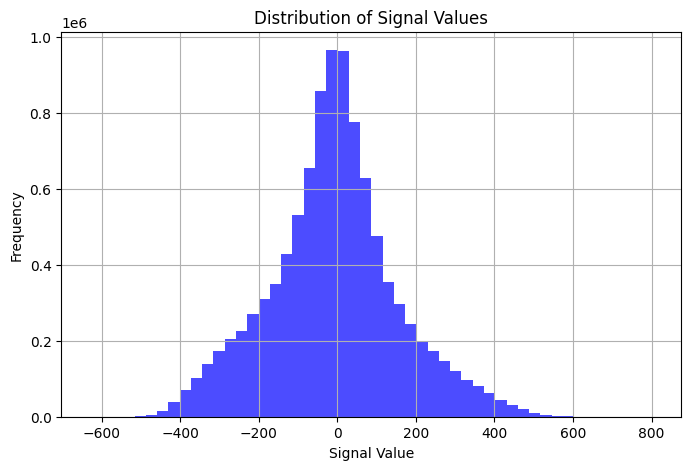

In [292]:
# 可視化信號值的分佈
plt.figure(figsize=(8, 5))
plt.hist(all_data.flatten(), bins=50, color='blue', alpha=0.7)
plt.title("Distribution of Signal Values")
plt.xlabel("Signal Value")
plt.ylabel("Frequency")
plt.grid()
plt.show()


### 可視化 label 分佈
- 圖示內容：展示數據標籤的分佈情況，檢查每個標籤的數據量。
- 目的：
  - 確保標籤分佈平衡，避免某些標籤的數據量過多或過少導致偏差。
  - 幫助理解數據集的整體結構。
- 應用場景：在模型訓練前確認類別不平衡問題，必要時進行數據重採樣。


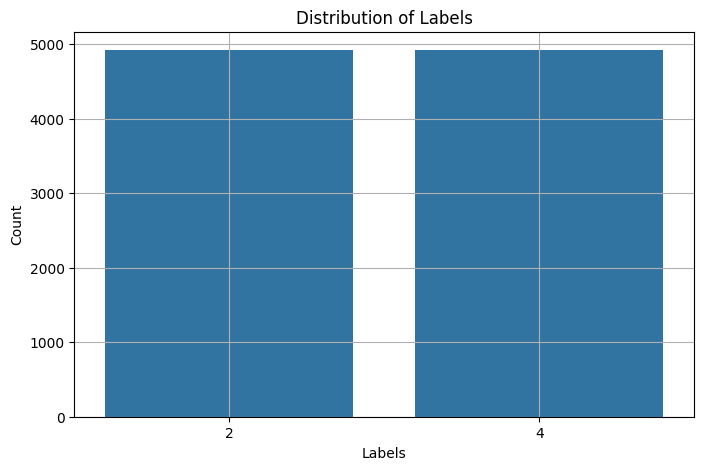

In [293]:
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(x=all_labels)
plt.title("Distribution of Labels")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.grid()
plt.show()


### 比較 Normalized 後的訊號
* 圖示內容：對比原始信號與正規化後的信號數據。
* 目的：
  * 驗證正規化過程是否成功，數據值範圍是否被縮放到目標範圍（如 [0, 1]）。
  * 確保正規化不會改變信號的主要特徵（如振幅相對大小和波形）。
- 解讀方式：
  - 值範圍縮放：確認信號值是否成功縮放到 [0, 1] 或 [-1, 1] 範圍內。
  - 相對特徵保留：正規化後，信號的形態應該與原始信號一致。例如，波形的峰值和谷值應仍在同一位置。
  - 縮放異常：檢查是否有數據被壓縮過度或偏移（如所有值都接近 0）。
  - 下一步：
    - 如果正規化後信號的形態發生明顯改變，需檢查正規化方法或考慮其他預處理技術（如標準化）。
* 應用場景：檢查數據預處理的質量，避免因正規化失誤導致信息丟失。

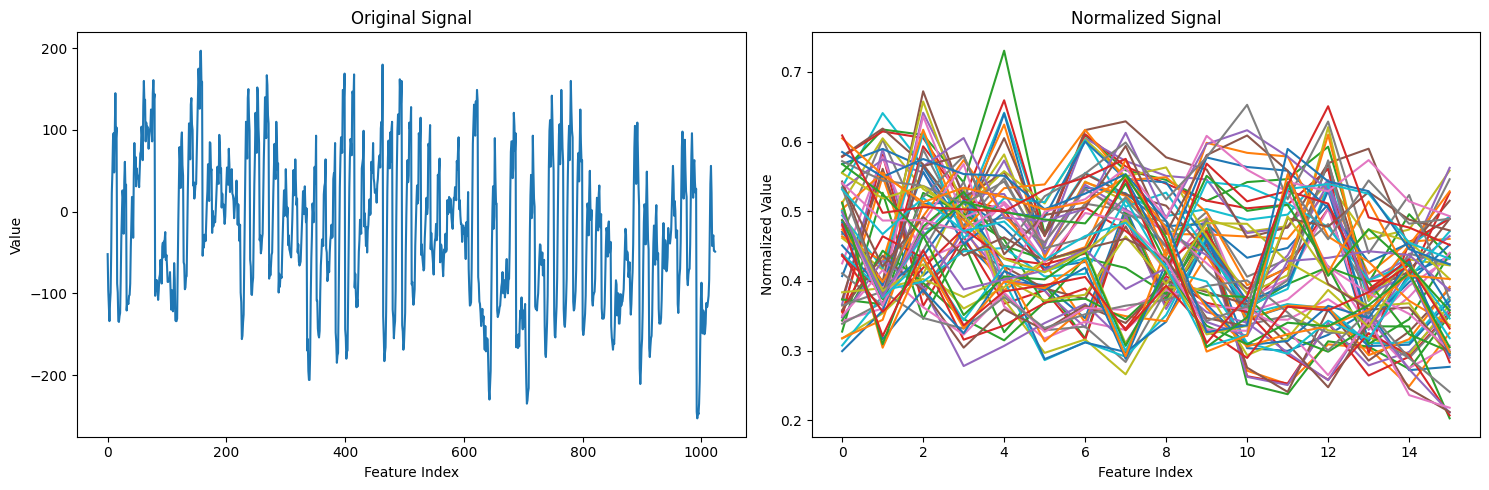

In [294]:
# 可視化正規化前後的信號
plt.figure(figsize=(15, 5))

# 原始信號
plt.subplot(1, 2, 1)
plt.plot(X_train[0])
plt.title("Original Signal")
plt.xlabel("Feature Index")
plt.ylabel("Value")

# 正規化信號
plt.subplot(1, 2, 2)
plt.plot(X_train_norm1[0])
plt.title("Normalized Signal")
plt.xlabel("Feature Index")
plt.ylabel("Normalized Value")

plt.tight_layout()
plt.show()


### 3D-data 的視覺化
* 圖示內容：展示自編碼器輸入的 3D 數據中，一個段的多通道信號數據。
* 目的：
  * 確認數據已按照分段和通道數正確塑形。
  * 可檢查多通道信號之間的同步性和一致性。
* 應用場景：在輸入深度學習模型（如自編碼器）之前檢查數據格式和結構是否正確。
* 解讀方式：
  * 通道間一致性：所有通道的信號模式應該有一定的關聯性，反映其來源（如腦波各通道之間的同步性）。
  * 段內特徵：每段信號應包含足夠的區別特徵，便於模型學習。
  * 異常波形：某些通道的信號如果呈現異常模式（如明顯高於或低於其他通道），可能需要進行通道去噪或調整。
  * 下一步：
    * 確認自編碼器輸入是否與設計目標一致，確保模型能有效學習多通道間的特徵。

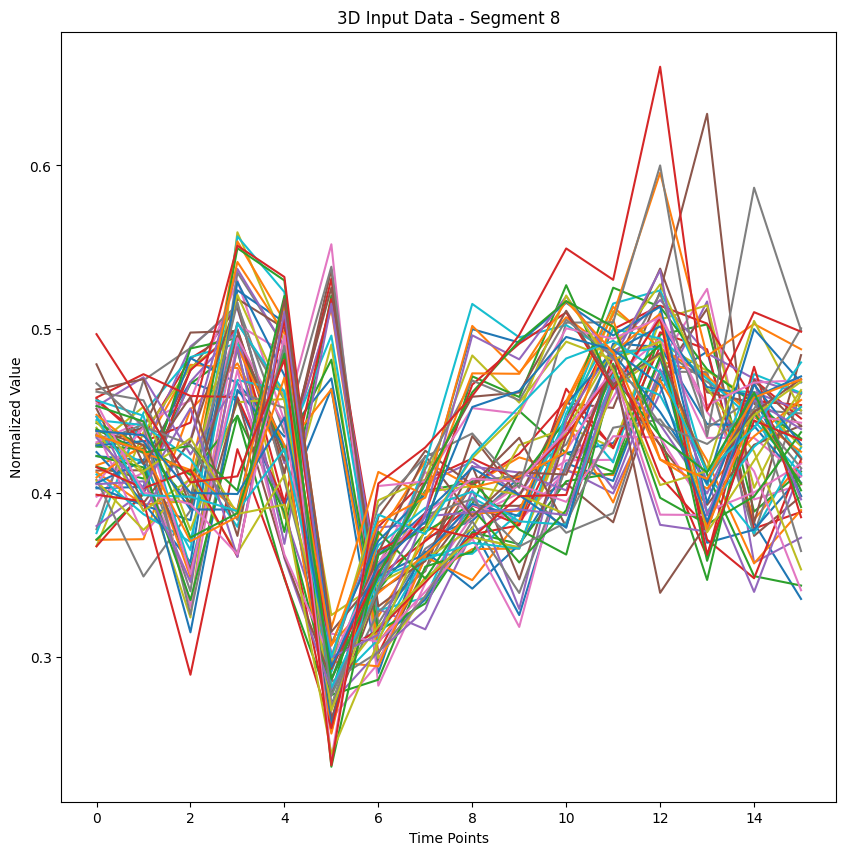

In [295]:
# 可視化 3D 數據的某一段
segment_id = 8  # 指定段
data_3d = X_train_norm1[segment_id]

plt.figure(figsize=(10, 10))
for channel in range(data_3d.shape[1]):
    plt.plot(data_3d[:, channel], label=f"Channel {channel + 1}")

plt.title(f"3D Input Data - Segment {segment_id}")
plt.xlabel("Time Points")
plt.ylabel("Normalized Value")
# plt.legend(loc='upper right', ncol=2)
plt.show()


###  PCA 或 t-SNE 降維視覺化
#### PCA
* 圖示內容：使用 PCA 將高維數據降維到 2D，並根據標籤進行著色。
* 目的：
  * 查看不同類別的數據分佈情況，檢查是否存在明顯的分類邊界。
  * 確保數據中包含一定的區分性，支持後續分類任務。
* 應用場景：檢查特徵提取的效果，以及數據類別是否可分。
* 解讀方式：
  * 如果同一類別數據形成緊湊的簇，則說明數據具有良好的分類性。
  * 類別之間的分佈是否有明顯邊界，反映特徵提取的效果。
  * 如果類別分佈混亂，可能意味著需要更強的特徵工程。
#### t-SNE
* 圖示內容：使用 t-SNE 將高維數據降維到 2D，並根據標籤進行著色。
* 目的：
  * 更適合處理非線性數據的降維，視覺化數據的潛在結構。
  * 幫助理解不同類別之間的分佈關係。
* 應用場景：進一步檢查數據是否存在內在結構性差異，用於評估分類難度。
  * t-SNE 更適合非線性分佈，能夠更清晰地揭示內部結構。
  * 如果同類數據形成孤立的團簇，則模型可以輕鬆區分類別。
  * 如果不同類別之間的距離模糊或重疊，分類難度可能較高。
    * 根據降維視覺化結果調整特徵提取方法或增加更具鑑別力的特徵。

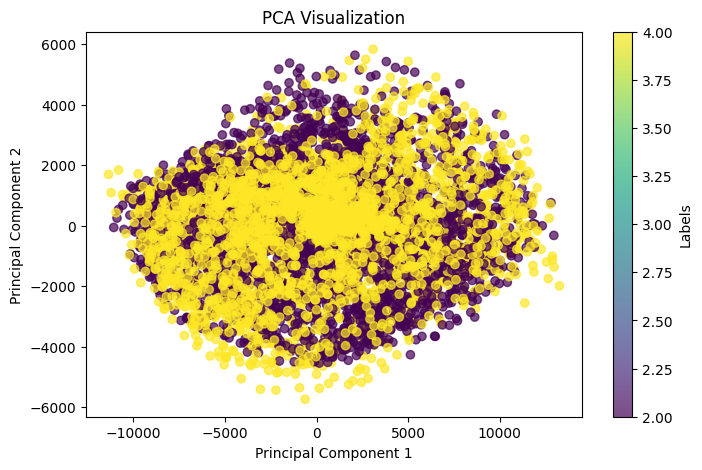

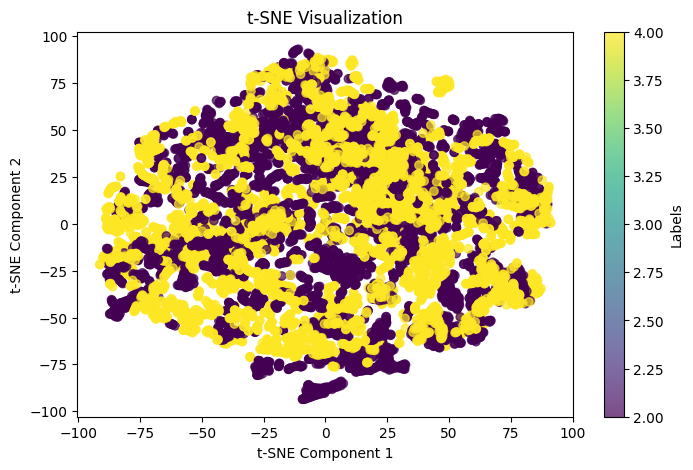

In [296]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# PCA 可視化
pca = PCA(n_components=2)
X_pca = pca.fit_transform(all_data)

plt.figure(figsize=(8, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=all_labels, cmap='viridis', alpha=0.7)
plt.title("PCA Visualization")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Labels")
plt.show()

# t-SNE 可視化
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(all_data)

plt.figure(figsize=(8, 5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=all_labels, cmap='viridis', alpha=0.7)
plt.title("t-SNE Visualization")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(label="Labels")
plt.show()


## AE + KNN (2 vs 4)

In [297]:
import torch
import torch.nn as nn
import torch.utils.data as Data
from sklearn.neighbors import KNeighborsClassifier


# 將數據轉換為 PyTorch 張量
X_train_norm1 = torch.tensor(X_train_norm1).float()
y_train = torch.tensor(y_train.flatten()).long()
X_test_norm1 = torch.tensor(X_test_norm1).float()
y_test = torch.tensor(y_test.flatten()).long()

# 超參數
LR = 0.005  # learning rate
EPOCH = 100
BATCH_size = 64

# 設置 data loader
train_data = Data.TensorDataset(X_train_norm1, y_train)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_size, shuffle=True)

# 定義 AutoEncoder
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(all_data.shape[1], 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 4),
        )
        self.decoder = nn.Sequential(
            nn.Linear(4, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, all_data.shape[1]),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

autoencoder = AutoEncoder()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
loss_func = nn.MSELoss()

# 訓練 AutoEncoder
knn = KNeighborsClassifier(n_neighbors=3)
best_acc = []

for epoch in range(EPOCH):
    autoencoder.train()
    for step, (b_x, b_y) in enumerate(train_loader):
        b_x_flat = b_x.view(b_x.size(0), -1)  # 展平输入
        encoded, decoded = autoencoder(b_x_flat)
        loss = loss_func(decoded, b_x_flat)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 100 == 0:
            print('Epoch: ', epoch, '| Step:', step, '| train loss: %.4f' % loss.item())

    # 評估 AutoEncoder
    autoencoder.eval()
    with torch.no_grad():
        X_train_flat = X_train_norm1.view(X_train_norm1.size(0), -1)
        X_test_flat = X_test_norm1.view(X_test_norm1.size(0), -1)

        encoded_train, _ = autoencoder(X_train_flat)
        encoded_test, _ = autoencoder(X_test_flat)
        knn.fit(encoded_train.numpy(), y_train.numpy())
        acc = knn.score(encoded_test.numpy(), y_test.numpy())
        best_acc.append(acc)
        print('Epoch: ', epoch, '| Test Accuracy: %.4f' % acc)

print('Best Test Accuracy:', max(best_acc))


Epoch:  0 | Step: 0 | train loss: 0.0315
Epoch:  0 | Step: 100 | train loss: 0.0100
Epoch:  0 | Test Accuracy: 0.5005
Epoch:  1 | Step: 0 | train loss: 0.0084
Epoch:  1 | Step: 100 | train loss: 0.0079
Epoch:  1 | Test Accuracy: 0.5127
Epoch:  2 | Step: 0 | train loss: 0.0073
Epoch:  2 | Step: 100 | train loss: 0.0077
Epoch:  2 | Test Accuracy: 0.5198
Epoch:  3 | Step: 0 | train loss: 0.0080
Epoch:  3 | Step: 100 | train loss: 0.0076
Epoch:  3 | Test Accuracy: 0.5229
Epoch:  4 | Step: 0 | train loss: 0.0083
Epoch:  4 | Step: 100 | train loss: 0.0074
Epoch:  4 | Test Accuracy: 0.5183
Epoch:  5 | Step: 0 | train loss: 0.0078
Epoch:  5 | Step: 100 | train loss: 0.0090
Epoch:  5 | Test Accuracy: 0.5208
Epoch:  6 | Step: 0 | train loss: 0.0140
Epoch:  6 | Step: 100 | train loss: 0.0086
Epoch:  6 | Test Accuracy: 0.5249
Epoch:  7 | Step: 0 | train loss: 0.0085
Epoch:  7 | Step: 100 | train loss: 0.0076
Epoch:  7 | Test Accuracy: 0.5361
Epoch:  8 | Step: 0 | train loss: 0.0091
Epoch:  8 | Ste